In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import librosa
import os
import multiprocessing
from sklearn.model_selection import train_test_split
from keras import utils


DEBUG = True
SILENCE_THRESHOLD = .01
RATE = 24000
N_MFCC = 13
COL_SIZE = 30
EPOCHS = 10


def get_wav(file_name):
    '''
    Load wav file from disk and down-samples to RATE
    '''
    y, sr = librosa.load('WavFormat/{}.wav'.format(file_name))
    print(file_name)
    return(librosa.core.resample(y=y, orig_sr=sr, target_sr=RATE, scale=True))


def to_mfcc(wav_array):
    '''
    Converts wav file to Mel Frequency Ceptral Coefficients
    '''
    return(librosa.feature.mfcc(y=wav_array, sr=RATE, n_mfcc=N_MFCC))


def split_people(df, test_size=0.2):
    '''
    Create train test split of DataFrame
    '''
    return train_test_split(df['filename'], df['native_language'], test_size=test_size, random_state=1234)


def to_categorical(y):
    '''
    Converts list of languages into a binary class matrix
    '''
    lang_dict = {}
    for index, language in enumerate(set(y)):
        lang_dict[language] = index
    y = list(map(lambda x: lang_dict[x], y))
    return utils.to_categorical(y, len(lang_dict))


def make_segments(mfccs, labels):
    '''
    Makes segments of mfccs and attaches them to the labels
    '''
    segments = []
    seg_labels = []
    for mfcc, label in zip(mfccs, labels):
        for start in range(0, int(mfcc.shape[1] / COL_SIZE)):
            segments.append(mfcc[:, start * COL_SIZE:(start + 1) * COL_SIZE])
            seg_labels.append(label)
    return(segments, seg_labels)



Using TensorFlow backend.
/home/niraj/anaconda3/envs/accent_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/niraj/anaconda3/envs/accent_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/niraj/anaconda3/envs/accent_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/niraj

In [2]:
df = pd.read_csv('Data/3_lang.csv')
X_train, X_test, y_train, y_test = split_people(df)

# Count of the training and testing samples
train_count = Counter(y_train)
test_count = Counter(y_test)

acc_to_beat = test_count.most_common(1)[0][1] / float(np.sum(list(test_count.values())))

# Converting to numerical categories
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print("Loading .wav files!!!")
pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
X_train = pool.map(get_wav, X_train)
X_test = pool.map(get_wav, X_test)
print("Conversion to MFCC!!!")
X_train = pool.map(to_mfcc, X_train)
X_test = pool.map(to_mfcc, X_test)
X_train, y_train = make_segments(X_train, y_train)
X_validation, y_validation = make_segments(X_test, y_test)
print("Done!!")

0.4041095890410959
Loading .wav files!!!
hindi5_roll2hindi4_pitch1

hindi22_roll2
spanish148
spanish34
hindi12_roll
spanish63
arabic125
spanish32
spanish45
arabic116
spanish105
hindi28_roll
hindi13_pitch2
arabic108
hindi23
spanish183
spanish48
hindi25_roll
hindi27_roll2
spanish218
hindi9_stretch1
hindi14_stretch1
hindi4_roll
spanish153
hindi20_pitch2
spanish118
hindi29_wn
hindi31
hindi32_stretch1
arabic126
hindi10_wn2
hindi25_roll2
hindi6_roll
arabic68
arabic123
hindi15_wn2
arabic69
arabic189
spanish8
hindi34_wn
spanish95
arabic63
hindi9_roll
hindi20
arabic129
arabic165
hindi6_wn
spanish177
arabic24
spanish102
hindi22_stretch2
arabic15
spanish181
arabic157
spanish226
arabic183
hindi2_pitch1
spanish28
hindi19
arabic51
spanish209
arabic114
hindi9_wn
arabic71
spanish62
hindi33_roll
spanish71
spanish50
hindi4_pitch2
spanish200
spanish39
hindi34
hindi13_stretch1
spanish133
hindi2_roll2
spanish42
hindi1
arabic40
hindi1_roll2
spanish21
spanish136
spanish188
hindi24_roll2
spanish97
spanish158


In [3]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [4]:
import keras
from keras.layers import BatchNormalization
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import MaxPooling2D, Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, TensorBoard

import pandas as pd
import matplotlib.pyplot as plt 
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def cnn_model(X_train,y_train,X_validation,y_validation, batch_size=64):
    
        '''
        Trains 2D convolutional neural network
        :param X_train: Numpy array of mfccs
        :param y_train: Binary matrix based on labels
        :return: CNN model
        '''
        
        rows = X_train[0].shape[0]
        cols = X_train[0].shape[1]
        val_rows = X_validation[0].shape[0]
        val_cols = X_validation[0].shape[1]
        num_classes = len(y_train[0])
        input_shape = (rows, cols, 1)
        X_train = X_train.reshape(X_train.shape[0], rows, cols, 1 )
        X_validation = X_validation.reshape(X_validation.shape[0],val_rows,val_cols,1)
    
        model = keras.models.Sequential([
            Conv2D(64, kernel_size=(3,3), activation='relu',
                         data_format="channels_last",
                         input_shape=input_shape),
            MaxPooling2D(pool_size=(2, 2)),
            BatchNormalization(),
            Conv2D(64,kernel_size=(3,3), activation='relu'),
            MaxPooling2D(pool_size=(2, 2)),
            BatchNormalization(),
            Dropout(0.25),
            Flatten(),
            Dense(128, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])
        model.compile(loss='categorical_crossentropy',
                      optimizer='adadelta',
                      metrics=['accuracy', f1_m, precision_m, recall_m])
    
        es = EarlyStopping(monitor='accuracy', min_delta=.005, patience=10, verbose=1, mode='auto')
        # Creates log file for graphical interpretation using TensorBoard
        tb = TensorBoard(log_dir='../logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=True,
                         write_images=True, embeddings_freq=0, embeddings_layer_names=None,
                         embeddings_metadata=None)
        # Image shifting
        datagen = ImageDataGenerator(width_shift_range=0.05)
        # Fit model using ImageDataGenerator
        history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=len(X_train) / 32
                        , epochs=(EPOCHS+5),
                        callbacks=[es,tb], validation_data=(X_validation,y_validation),verbose = 2)
    
        return (model)

In [83]:
from sklearn.ensemble import RandomForestClassifier
import sklearn
import math

def rf(X_train,y_train,X_validation,y_validation):
    df = pd.DataFrame(data=np.array(y_train), columns=["column1", "column2","column3"])
    df['categorical'] = df[df.columns[1:]].apply(lambda x: ','.join(x.dropna().astype(int).astype(str)),axis=1)
    df.drop(['column1', 'column2','column3'], axis = 1, inplace = True)
    df.loc[df['categorical'] == '0,0',:] = 1
    df.loc[df['categorical'] == '1,0',:] = 2
    df.loc[df['categorical'] == '0,1',:] = 0
    X_train1=np.array(X_train)
    df1 = pd.DataFrame(X_train1.reshape(X_train1.shape[0],X_train1.shape[1] * X_train1.shape[2]))
    X_test1=np.array(X_validation)
    df3 = pd.DataFrame(X_test1.reshape(X_test1.shape[0],X_test1.shape[1] * X_test1.shape[2]))
    df5 = pd.DataFrame(data=np.array(y_validation), columns=["column1", "column2","column3"])
    df5['categorical'] = df5[df5.columns[1:]].apply(lambda x: ','.join(x.dropna().astype(int).astype(str)),axis=1)
    df5.drop(['column1', 'column2','column3'], axis = 1, inplace = True)
    df5.loc[df5['categorical'] == '0,0',:] = 0
    df5.loc[df5['categorical'] == '0,1',:] = 1
    df5.loc[df5['categorical'] == '1,0',:] = 2
    rfc = RandomForestClassifier()
    df = df.to_numpy()
    rfc.fit(df1, np.ravel(df).astype('int'))
    y_pred = rfc.predict(df3)
    mse = sklearn.metrics.mean_squared_error(df5['categorical'], y_pred)
    rmse = math.sqrt(mse)
    print('Accuracy for Random Forest',100*rmse)

In [88]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import sklearn
import math

def gb(X_train,y_train,X_validation,y_validation):
    df = pd.DataFrame(data=np.array(y_train), columns=["column1", "column2","column3"])
    df['categorical'] = df[df.columns[1:]].apply(lambda x: ','.join(x.dropna().astype(int).astype(str)),axis=1)
    df.drop(['column1', 'column2','column3'], axis = 1, inplace = True)
    df.loc[df['categorical'] == '0,0',:] = 1
    df.loc[df['categorical'] == '1,0',:] = 2
    df.loc[df['categorical'] == '0,1',:] = 0
    X_train1=np.array(X_train)
    df1 = pd.DataFrame(X_train1.reshape(X_train1.shape[0],X_train1.shape[1] * X_train1.shape[2]))
    X_test1=np.array(X_validation)
    df3 = pd.DataFrame(X_test1.reshape(X_test1.shape[0],X_test1.shape[1] * X_test1.shape[2]))
    df5 = pd.DataFrame(data=np.array(y_validation), columns=["column1", "column2","column3"])
    df5['categorical'] = df5[df5.columns[1:]].apply(lambda x: ','.join(x.dropna().astype(int).astype(str)),axis=1)
    df5.drop(['column1', 'column2','column3'], axis = 1, inplace = True)
    df5.loc[df5['categorical'] == '0,0',:] = 0
    df5.loc[df5['categorical'] == '0,1',:] = 1
    df5.loc[df5['categorical'] == '1,0',:] = 2
    gb_clf = GradientBoostingClassifier(n_estimators=10)
    df = df.to_numpy()
    gb_clf.fit(df1, np.ravel(df).astype('int'))
    y_pred = gb_clf.predict(df3)
    mse = sklearn.metrics.mean_squared_error(df5['categorical'], y_pred)
    rmse = math.sqrt(mse)
    print('Accuracy for Gradient Boosting',100*rmse)

In [202]:
import keras
from keras.layers import BatchNormalization
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import MaxPooling2D, Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, TensorBoard

import pandas as pd
import matplotlib.pyplot as plt 

def nn_model(X_train,y_train,X_validation,y_validation, batch_size=64):
    
        '''
        Trains 2D convolutional neural network
        :param X_train: Numpy array of mfccs
        :param y_train: Binary matrix based on labels
        :return: CNN model
        '''
        
        rows = X_train[0].shape[0]
        cols = 1
        val_rows = X_validation[0].shape[0]
        val_cols = 1
        num_classes = len(y_train[0])
        input_shape = (rows, cols, 1)
        X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] * X_train.shape[2])
        X_validation = X_validation.reshape(X_validation.shape[0],X_validation.shape[1] * X_validation.shape[2])
    
        model = keras.models.Sequential([
            Dense(512, activation='relu', input_shape=(X_train.shape[1:])),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dropout(0.25),
            Dense(512, activation='relu'),
            Dense(num_classes, activation='softmax')
        ])
        model.compile(loss='categorical_crossentropy',
                      optimizer='adadelta',
                      metrics=['accuracy'])
    
        history = model.fit(X_train,y_train, batch_size = batch_size,epochs = EPOCHS, validation_data=(X_validation,y_validation),verbose = 2)
        pd.DataFrame(history.history).plot(figsize = (10,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()
    
        return (model)

In [5]:
model = cnn_model(np.array(X_train), np.array(y_train), np.array(X_validation),np.array(y_validation))


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/15
 - 27s - loss: 0.8586 - accuracy: 0.5966 - f1_m: 0.5589 - precision_m: 0.6930 - recall_m: 0.4714 - val_loss: 0.8092 - val_accuracy: 0.5743 - val_f1_m: 0.5143 - val_precision_m: 0.6093 - val_recall_m: 0.4618
Epoch 2/15
 - 26s - loss: 0.7068 - accuracy: 0.6696 - f1_m: 0.6355 - precision_m: 0.7676 - recall_m: 0.5439 - val_loss: 0.7530 - val_accuracy: 0.6314 - val_f1_m: 0.5912 - val_precision_m: 0.6902 - val_recall_m: 0.5244
Epoch 3/15
 - 26s - loss: 0.6575 - accuracy: 0.6997 - f1_m: 0.6740 - precision_m: 0.7768 - recall_m: 0.5966 - val_loss: 0.6980 - val_accuracy: 0.6577 - val_f1_m: 0.6071 - val_precision_m: 0.6982 - val_recall_m: 0.5459
Epoch 4/15
 - 26s - loss: 0.6212 - accuracy: 0.7203 - f1_m: 0.7015 - precision_m: 0.7848 - recall_m: 0.6354 - val_loss: 0.7583 - val_accuracy: 0.6531 - val_f1_m: 0.6218 - val_precision_m: 0.6942 - val_recall_m: 0.5684
Epoch 5/

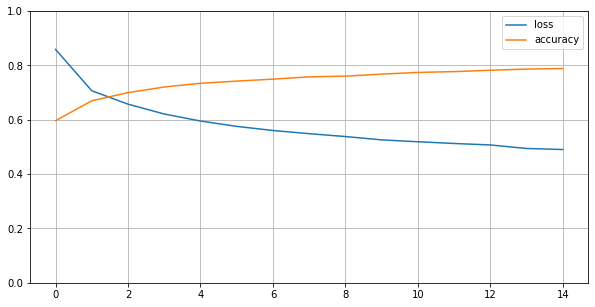

In [6]:
keys = ['loss', 'accuracy']
        
pd.DataFrame({key: model.history.history[key] for key in keys}).plot(figsize = (10,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

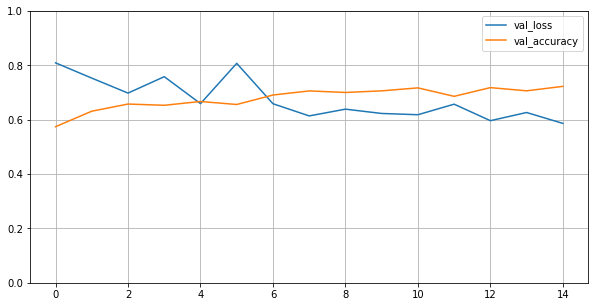

In [7]:
keys = ['val_loss', 'val_accuracy']
        
pd.DataFrame({key: model.history.history[key] for key in keys}).plot(figsize = (10,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [92]:
rf(X_train, y_train,X_validation,y_validation)

Accuracy for Random Forest 60.23398239402392


In [110]:
gb(X_train,y_train,X_validation,y_validation)

Accuracy for Gradient Boosting 65.24134230293403


In [104]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               200192    
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
batch_normalization_5 (Batch (None, 512)              

In [8]:
from collections import Counter
import numpy as np

def predict_class_audio(MFCCs, model):
    '''
    Predict class based on MFCC samples
    :param MFCCs: Numpy array of MFCCs
    :param model: Trained model
    :return: Predicted class of MFCC segment group
    '''
    MFCCs = MFCCs.reshape(MFCCs.shape[0],MFCCs.shape[1],MFCCs.shape[2],1)
    y_predicted = model.predict_classes(MFCCs,verbose=0)
    return(Counter(list(y_predicted)).most_common(1)[0][0])


def predict_prob_class_audio(MFCCs, model):
    '''
    Predict class based on MFCC samples' probabilities
    :param MFCCs: Numpy array of MFCCs
    :param model: Trained model
    :return: Predicted class of MFCC segment group
    '''
    MFCCs = MFCCs.reshape(MFCCs.shape[0],MFCCs.shape[1],MFCCs.shape[2],1)
    y_predicted = model.predict_proba(MFCCs,verbose=0)
    return(np.argmax(np.sum(y_predicted,axis=0)))

def predict_class_all(X_train, model):
    '''
    :param X_train: List of segmented mfccs
    :param model: trained model
    :return: list of predictions
    '''
    predictions = []
    for mfcc in X_train:
        predictions.append(predict_class_audio(mfcc, model))
        # predictions.append(predict_prob_class_audio(mfcc, model))
    return predictions

def confusion_matrix(y_predicted,y_test):
    '''
    Create confusion matrix
    :param y_predicted: list of predictions
    :param y_test: numpy array of shape (len(y_test), number of classes). 1.'s at index of actual, otherwise 0.
    :return: numpy array. confusion matrix
    '''
    confusion_matrix = np.zeros((len(y_test[0]),len(y_test[0])),dtype=int )
    for index, predicted in enumerate(y_predicted):
        confusion_matrix[np.argmax(y_test[index])][predicted] += 1
    return(confusion_matrix)

def get_accuracy(y_predicted,y_test):
    '''
    Get accuracy
    :param y_predicted: numpy array of predictions
    :param y_test: numpy array of actual
    :return: accuracy
    '''
    c_matrix = confusion_matrix(y_predicted,y_test)
    return( np.sum(c_matrix.diagonal()) / float(np.sum(c_matrix)))
def segment_one(mfcc):
    '''
    Creates segments from on mfcc image. If last segments is not long enough to be length of columns divided by COL_SIZE
    :param mfcc (numpy array): MFCC array
    :return (numpy array): Segmented MFCC array
    '''
    segments = []
    for start in range(0, int(mfcc.shape[1] / COL_SIZE)):
        segments.append(mfcc[:, start * COL_SIZE:(start + 1) * COL_SIZE])
    return(np.array(segments))

def create_segmented_mfccs(X_train):
    '''
    Creates segmented MFCCs from X_train
    :param X_train: list of MFCCs
    :return: segmented mfccs
    '''
    segmented_mfccs = []
    for mfcc in X_train:
        segmented_mfccs.append(segment_one(mfcc))
    return(segmented_mfccs)



Training samples: Counter({'hindi': 247, 'spanish': 184, 'arabic': 151})
Testing samples: Counter({'hindi': 59, 'spanish': 44, 'arabic': 43})
Accuracy to beat: 0.4041095890410959
Confusion matrix of total samples:
 [59 44 43]
Confusion matrix:
 [[57  0  2]
 [ 2 26 16]
 [ 0 13 30]]
Accuracy: 0.773972602739726


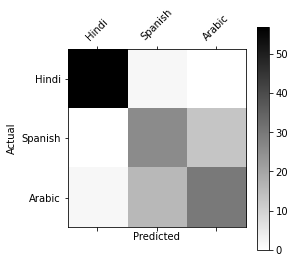

In [21]:
import matplotlib.pyplot as plt
y_predicted = predict_class_all(create_segmented_mfccs(X_test), model)
target_names = ['Hindi', 'Spanish', 'Arabic']

# Print statistics
print('Training samples:', train_count)
print('Testing samples:', test_count)
print('Accuracy to beat:', acc_to_beat)
print('Confusion matrix of total samples:\n', np.sum(confusion_matrix(y_predicted, y_test),axis=1))
print('Confusion matrix:\n',confusion_matrix(y_predicted, y_test))
print('Accuracy:', get_accuracy(y_predicted,y_test))

arr = []

for a in y_test:
    arr.append(int(np.where(a == 1)[0]))
y_pred = pd.Series(y_predicted, name='Actual')
y_te = pd.Series(arr, name='Predicted')
df_confusion = pd.crosstab(y_pred, y_te)

def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    
plot_confusion_matrix(df_confusion)

In [24]:
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import MultiLabelBinarizer

binarizer = MultiLabelBinarizer()

y_p = predict_class_all(create_segmented_mfccs(X_test), model)
target_names = ['Hindi', 'Spanish', 'Arabic']

arr = []
for a in y_test:
    arr.append(int(np.where(a == 1)[0]))

print(classification_report(arr, y_p, target_names=target_names))

              precision    recall  f1-score   support

       Hindi       0.97      0.97      0.97        59
     Spanish       0.67      0.59      0.63        44
      Arabic       0.62      0.70      0.66        43

    accuracy                           0.77       146
   macro avg       0.75      0.75      0.75       146
weighted avg       0.78      0.77      0.77       146



In [23]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = 100 * np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45, size=12.5)
        plt.yticks(tick_marks, target_names, size=12.5)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", size=15)


    plt.tight_layout()
    plt.ylabel('True label', size=15)
    plt.xlabel('Predicted label\nAccuracy={:0.2f}%'.format(accuracy), size=17.5)
    plt.show()

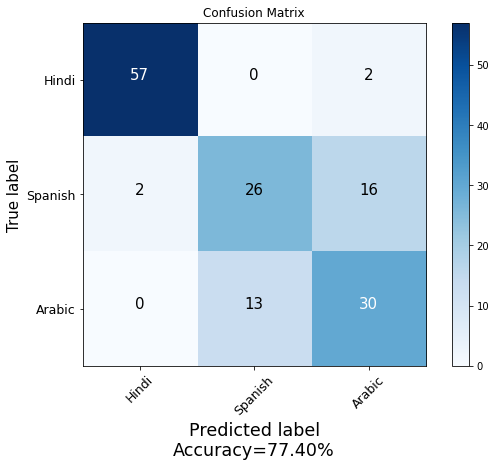

In [24]:
plot_confusion_matrix(cm           = np.array([[57,  0,  2],
 [ 2, 26, 16],
 [ 0, 13, 30]]), 
                      normalize    = False,
                      target_names = ['Hindi', 'Spanish', 'Arabic'],
                      title        = "Confusion Matrix")